In [1]:
import tensorflow as tf
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(
    1001
)

fashion_mnist = tf.keras.datasets.fashion_mnist


In [ ]:
fashion_mnist

<module 'keras.api._v2.keras.datasets.fashion_mnist' from '/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/datasets/fashion_mnist/__init__.py'>

In [ ]:
classes = ['Upper clothes', 'Lower clothes', 'Shoes']

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# reshape for feeding into the model
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(len(x_train))
print(len(x_test))

60000
10000


In [ ]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
def replace_classes(arr, values, num_new):
  '''
  arr - original array of class names/numbers
  values - 2d array with collections of classes from original dataset grouped
          by their new values
  num_new - int value that matches the number of new classes
  -----
  Returns:
  arr - original array modified so that all classes are replaced by the number
        of their group
  not_in_legit_vals_indexes - indexes of rows that do not belong to any of the
                              new groups
  '''
  legit_vals = []
  for i in range(num_new):
    arr = np.where(np.isin(arr, values[i]), i, arr)
    legit_vals.append(i)

  print(legit_vals)
  not_in_legit_vals_indexes = np.where(~np.isin(arr, legit_vals))[0]
  return arr, not_in_legit_vals_indexes


In [ ]:
def remove_classes(xs, ys, indexes):
  '''
  xs - numpy arrays of images
  ys - array of classes
  indexes - array of indexes of rows that should be deleted from xs and ys
  ---
  Returns:
  xs, ys - modified image and label arrays
  '''
  xs = np.delete(xs, indexes, axis=0)
  ys = np.delete(ys, indexes, axis=0)
  return xs, ys


In [ ]:
upper_classes = [0, 2, 3, 4, 6]
lower_classes = [1]
shoes_classes = [5, 7, 9]
joint_classes = [upper_classes, lower_classes, shoes_classes]
num_classes = 3

In [ ]:
y_train, rm_train = replace_classes(y_train, joint_classes, num_classes)
y_test, rm_test = replace_classes(y_test, joint_classes, num_classes)

[0, 1, 2]
[0, 1, 2]


In [ ]:
x_train, y_train = remove_classes(x_train, y_train, rm_train)
x_test, y_test = remove_classes(x_test, y_test, rm_test)
len(x_train)

54000

In [ ]:
X = np.concatenate((x_train, x_test))
Y = np.concatenate((y_train, y_test))

(array([35000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  7000.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 21000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

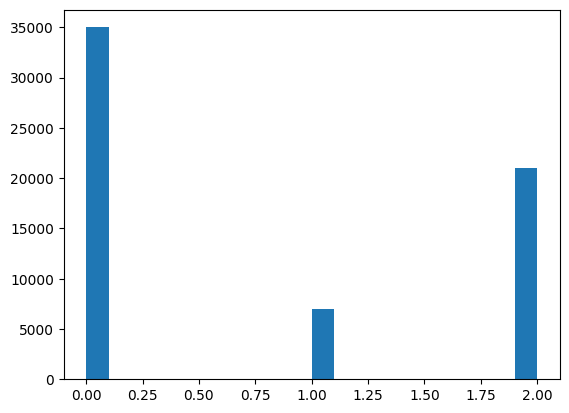

In [ ]:
len(X)
plt.hist(Y, bins='auto')


In [ ]:
np.unique(Y, return_counts=True)

(array([0, 1, 2], dtype=uint8), array([35000,  7000, 21000]))

In [ ]:
type(X[0])
np.shape(X)

(63000, 28, 28, 1)

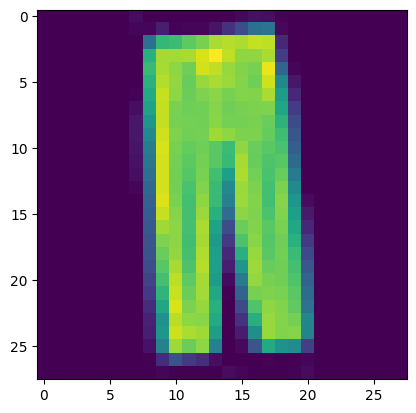

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2)
])

test_im = data_augmentation(X[21])
plt.imshow(test_im)

height = X.shape[1]
width = X.shape[2]
channels = X.shape[3]

def augment_data_class(X,Y,class_num, data_augmentation):
  max_count = 30000
  class_ind = np.argwhere(Y == class_num)
  ind = 0
  start_ind = class_ind[0]
  print(start_ind, type(start_ind[0]))
  plt.imshow(X[start_ind[0]])
  count = np.count_nonzero(Y == class_num)
  count0 = count

  while count < max_count:
    print('New ind:', start_ind[0])
    image = X[start_ind[0]]  # Assuming image is already in the correct format
    print('image shape before expansion: ',np.shape(image))
    image = np.expand_dims(image, axis=0)
    print('image shape after expansion: ',np.shape(image))
    for i in range(4):
      new_im = data_augmentation(image)
      #new_im = X[start_ind[0]]
      new_im = np.expand_dims(new_im, axis=-1)
      print('shape new_im: ', np.shape(new_im))
      X = np.concatenate((X, new_im), axis=0)
      Y = np.append(Y, class_num)
      print('image shape after reduction: ',np.shape(new_im))
    if ind < count-1:
      ind += 1
    else:
      ind = 0
    start_ind = class_ind[ind]
    print('start ind:', start_ind)
    count = np.count_nonzero(Y == class_num)
    print(count)
    print('shape of x=', np.shape(X))

  return X, Y

In [ ]:
#X_mod, Y_mod = augment_data_class(X,Y,1,data_augmentation)
def double_data(X,Y,class_num):
  class_ind = np.argwhere(Y == class_num).flatten()
  num = len(class_ind)
  double_ind = np.random.choice(class_ind, size=int(num/2))
  res_x = [X[i] for i in double_ind]
  res_y = [Y[i] for i in double_ind]
  X = np.append(X, res_x, axis=0)
  Y = np.append(Y, res_y, axis=0)
  return X, Y


In [ ]:
modx, mody = augment_data_class(X, Y, 1, data_augmentation)
X, Y = augment_data_class(modx, mody, 2, data_augmentation)

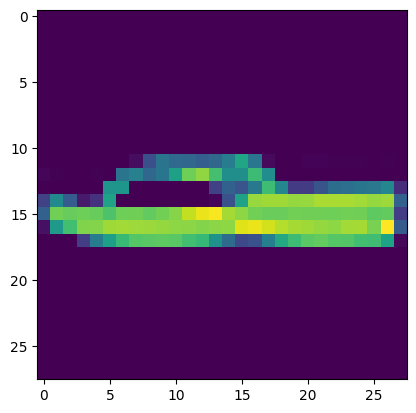

In [ ]:
plt.imshow(X[70000])

In [ ]:
def display_images(x_train, y_train):
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x_train[i], cmap=plt.cm.binary)
      plt.xlabel(y_train[i])
  plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [ ]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y), y=Y)
class_weights = dict(enumerate(weights))

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=40)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=40)

NameError: name 'train_test_split' is not defined

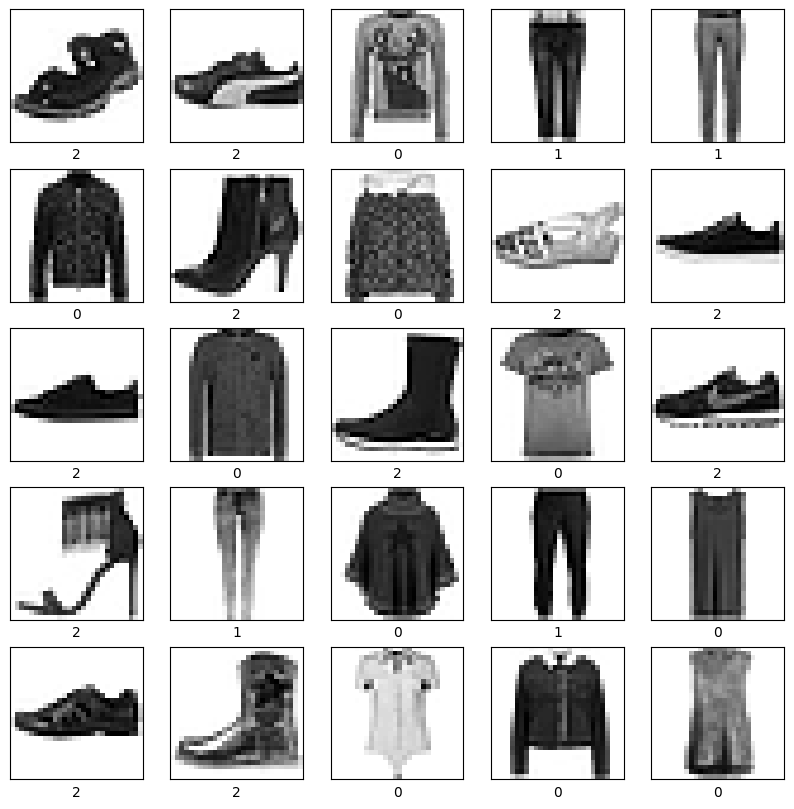

In [ ]:
display_images(X_val, y_val)

In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array([0, 1, 2], dtype=uint8), array([24500,  7350, 22050]))
(array([0, 1, 2], dtype=uint8), array([5250, 1575, 4725]))
(array([0, 1, 2], dtype=uint8), array([5250, 1575, 4725]))


In [ ]:
from tensorflow.keras.utils import plot_model

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu')
])


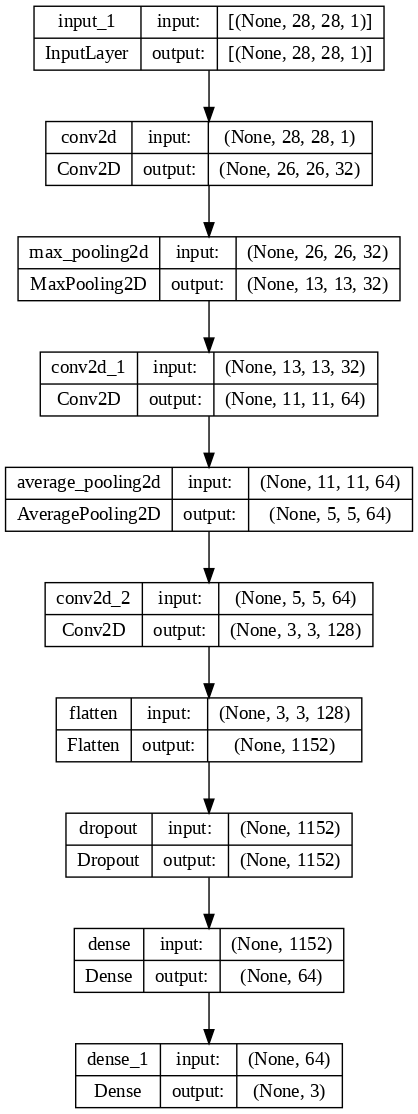

In [ ]:
plot_model(model, to_file='model.png',
           show_shapes=True, dpi=100,
           show_layer_names=True)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



NameError: name 'model' is not defined

In [ ]:
history = model.fit(X_train, y_train, epochs=3,
                    validation_data=(X_val, y_val))


NameError: name 'model' is not defined

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)


NameError: name 'model' is not defined

In [ ]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

361/361 [==============================] - 4s 9ms/step


In [ ]:
print(np.unique(predictions))
print(np.unique(y_test))

[0 1 2]
[0 1 2]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
history

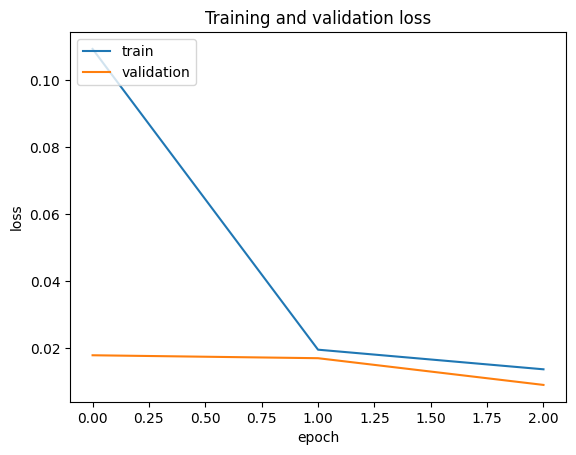

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

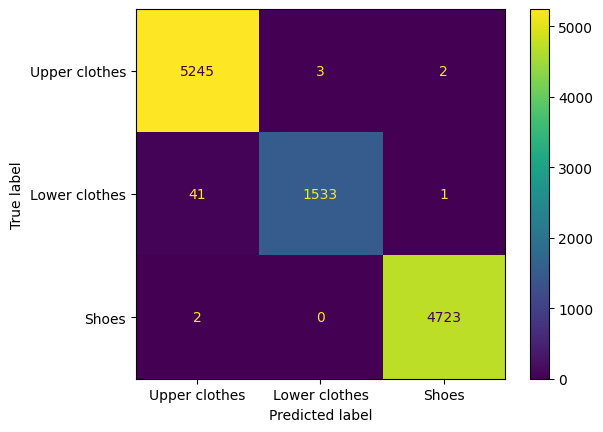

In [ ]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Upper clothes','Lower clothes','Shoes']).plot()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5250
           1       1.00      0.97      0.99      1575
           2       1.00      1.00      1.00      4725

    accuracy                           1.00     11550
   macro avg       1.00      0.99      0.99     11550
weighted avg       1.00      1.00      1.00     11550



In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu')
])

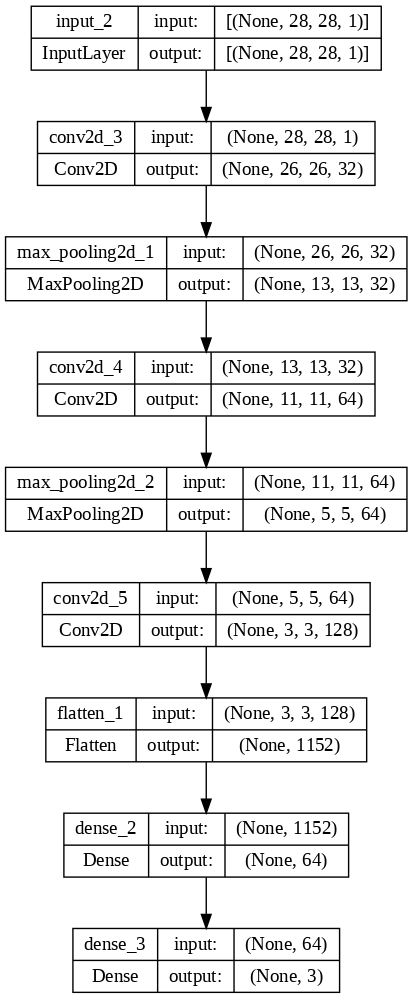

In [ ]:
plot_model(model1, to_file='model1.png',
           show_shapes=True, dpi=100,
           show_layer_names=True)

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

(array([5250.,    0.,    0.,    0.,    0.,    0.,    0., 1575.,    0.,
           0.,    0.,    0.,    0.,    0., 4725.]),
 array([0.        , 0.13333333, 0.26666667, 0.4       , 0.53333333,
        0.66666667, 0.8       , 0.93333333, 1.06666667, 1.2       ,
        1.33333333, 1.46666667, 1.6       , 1.73333333, 1.86666667,
        2.        ]),
 <BarContainer object of 15 artists>)

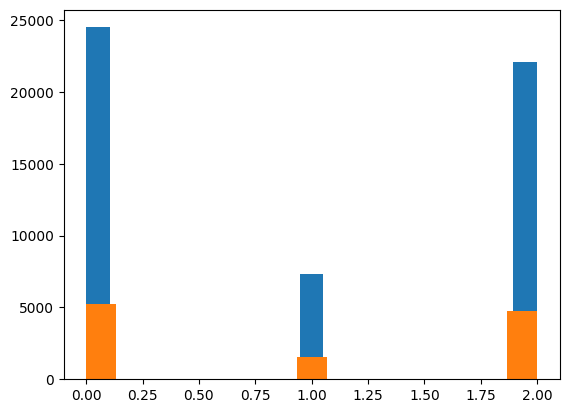

In [ ]:
plt.hist(y_train, bins='auto')
plt.hist(y_val, bins='auto')

In [ ]:
history1 = model1.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
1685/1685 [==============================] - 57s 34ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0080 - val_accuracy: 0.9983
Epoch 2/5
1685/1685 [==============================] - 52s 31ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0079 - val_accuracy: 0.9984
Epoch 3/5
1685/1685 [==============================] - 52s 31ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0094 - val_accuracy: 0.9977
Epoch 4/5
1685/1685 [==============================] - 51s 30ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0080 - val_accuracy: 0.9981
Epoch 5/5
1685/1685 [==============================] - 50s 30ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0084 - val_accuracy: 0.9985


In [ ]:
test_loss, test_acc = model1.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

361/361 - 3s - loss: 0.0160 - accuracy: 0.9973 - 3s/epoch - 7ms/step

Test accuracy: 0.9973160028457642


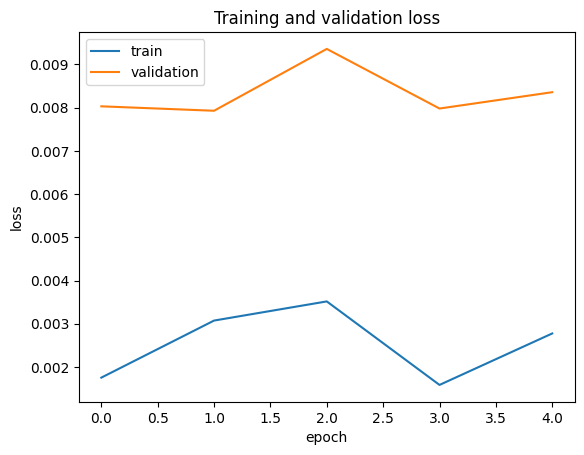

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
tf.keras.utils.save_img('img.png', X_train[0])

361/361 [==============================] - 4s 11ms/step


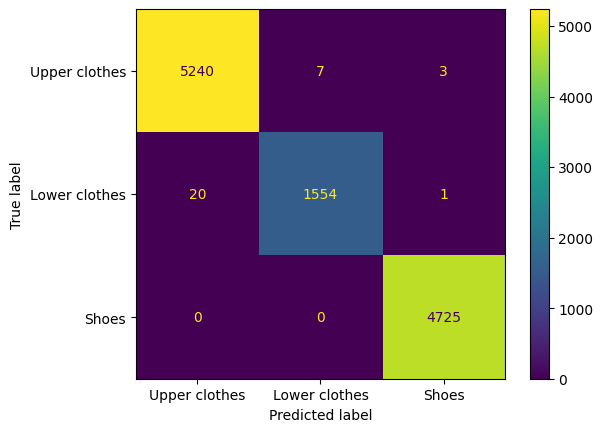

In [ ]:
predictions = model1.predict(X_test)
predictions = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Upper clothes','Lower clothes','Shoes']).plot()

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.AveragePooling2D(strides=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.AveragePooling2D(strides=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.AveragePooling2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu')
])

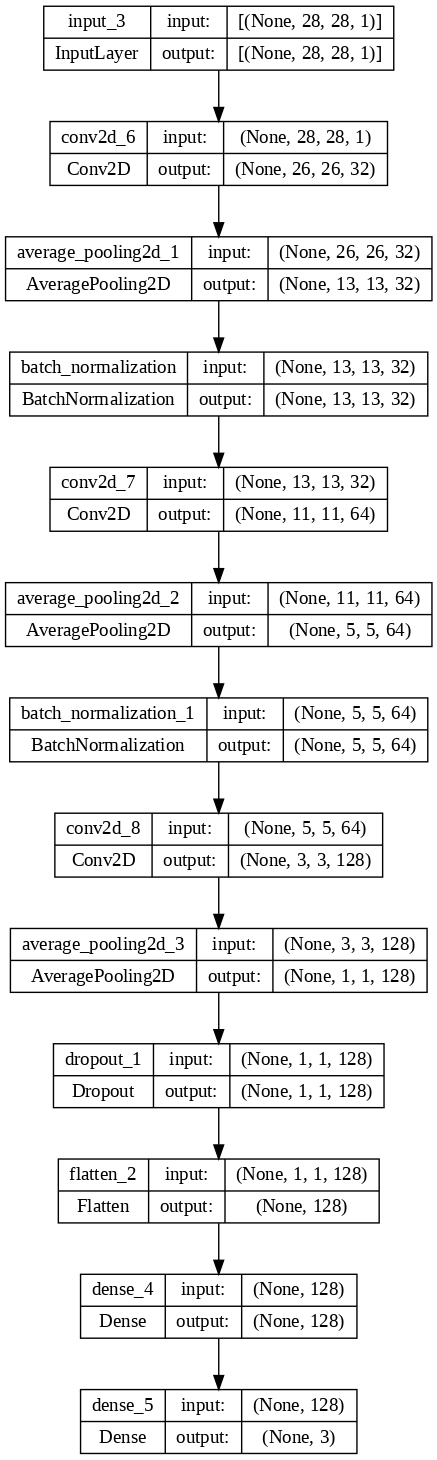

In [ ]:
plot_model(model2, to_file='model2.png',
           show_shapes=True, dpi=100,
           show_layer_names=True)

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
1685/1685 [==============================] - 52s 29ms/step - loss: 0.0397 - accuracy: 0.9883 - val_loss: 0.0201 - val_accuracy: 0.9941
Epoch 2/5
1685/1685 [==============================] - 47s 28ms/step - loss: 0.0220 - accuracy: 0.9932 - val_loss: 0.0281 - val_accuracy: 0.9952
Epoch 3/5
1685/1685 [==============================] - 48s 28ms/step - loss: 0.0170 - accuracy: 0.9947 - val_loss: 0.0111 - val_accuracy: 0.9963
Epoch 4/5
1685/1685 [==============================] - 50s 29ms/step - loss: 0.0148 - accuracy: 0.9953 - val_loss: 0.0217 - val_accuracy: 0.9943
Epoch 5/5
1685/1685 [==============================] - 48s 29ms/step - loss: 0.0129 - accuracy: 0.9958 - val_loss: 0.0119 - val_accuracy: 0.9966


In [ ]:
test_loss, test_acc = model2.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

361/361 - 3s - loss: 0.0130 - accuracy: 0.9969 - 3s/epoch - 8ms/step

Test accuracy: 0.9968830943107605


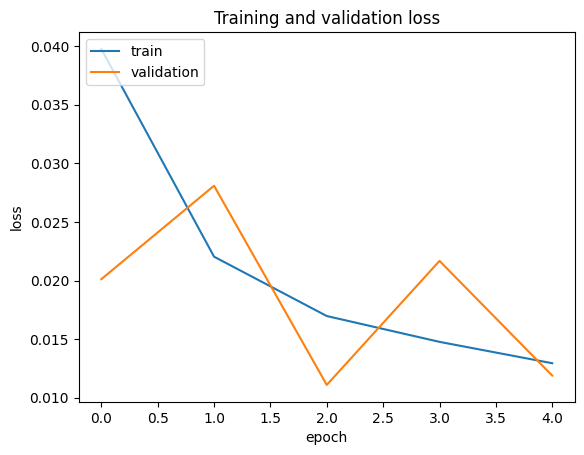

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

361/361 [==============================] - 4s 11ms/step


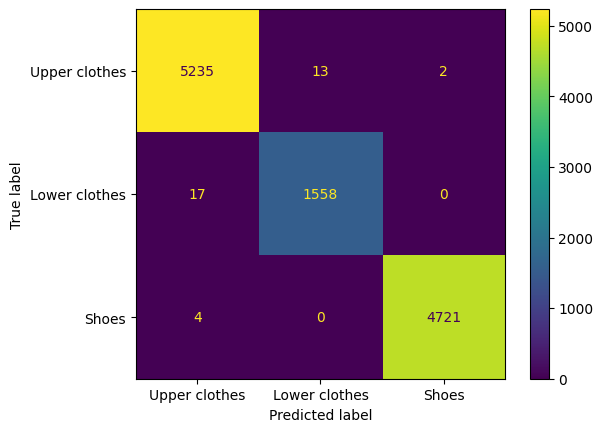

In [ ]:
predictions = model2.predict(X_test)
predictions = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Upper clothes','Lower clothes','Shoes']).plot()

In [ ]:
import os

os.mkdir('testing_data')

In [ ]:
model.save('model.keras')
model1.save('model1.keras')
model2.save('model2.keras')